In [ ]:
#finalBlend

In [1]:
import pandas as pd
import numpy as np
import gc
import itertools
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from helpers.funcs import resample, single_ts_split, timeseries_train_test_split as TSSplit, fit_model_cv
import matplotlib.pyplot as plt
%matplotlib inline
NB_SEED = 123123

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  retu

In [2]:
def setindexdatetime(df, index_col):
    df[index_col] = pd.to_datetime(df[index_col])
    df.set_index(index_col, inplace=True)
    df = df.astype(np.float)
    return df

In [3]:
tr = setindexdatetime(pd.read_csv('valids/v_ready_iqr_tr.csv'),'Timestamp')
ts = setindexdatetime(pd.read_csv('valids/v_ready_iqr_ts.csv'),'Timestamp')

In [4]:
tr.index.freq = '15T'

In [5]:
ts = resample(ts)

/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:39: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  tseries.index[0], pd.tslib.Timestamp), 'Object must have a datetime-like index.'
/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:73: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  tseries = tseries.resample(short_rate, how='mean').interpolate()
/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:76: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).ffill()
  tseries = tseries.resample(rate, how='ffill')


In [6]:
tr_Target = tr.Target.copy()

In [7]:
######## ADDING TIME RELATED FEATURES TO DATA #########
# Not adding time features, lowers accuracy in this step

In [8]:
from sklearn.preprocessing import MinMaxScaler
trsc = MinMaxScaler()
tssc = MinMaxScaler()
tr_nf = tr.loc[:,tr.dtypes!="float64"]
ts_nf = ts.loc[:,ts.dtypes!="float64"]
tr_cont = tr.loc[:,tr.dtypes=="float64"].drop('Target',1)
tr_cont_names = tr_cont.columns.values
tr_cont_idx = tr_cont.index
ts_cont = ts.loc[:,ts.dtypes=="float64"]
ts_cont_names = ts_cont.columns.values
ts_cont_idx = ts_cont.index
tr_cont = trsc.fit_transform(tr_cont)
ts_cont = tssc.fit_transform(ts_cont)
tr_cont = pd.DataFrame(tr_cont)
ts_cont = pd.DataFrame(ts_cont)
tr_cont.columns = tr_cont_names
ts_cont.columns = ts_cont_names
tr_cont.index = tr_cont_idx
ts_cont.index = ts_cont_idx

tr_num = tr_nf.join(tr_cont).join(tr_Target)
ts_num = ts_nf.join(ts_cont)

In [9]:
from sklearn.linear_model import LinearRegression, ElasticNet, HuberRegressor, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [10]:
rf = RandomForestRegressor(n_estimators=200,n_jobs=-1,random_state=NB_SEED)
ada = AdaBoostRegressor(random_state=NB_SEED)
ext = ExtraTreesRegressor(random_state=NB_SEED)
lr = LinearRegression(n_jobs=-1)
enet = ElasticNet(random_state=NB_SEED,l1_ratio=0.2)
hbr = HuberRegressor()
rdg = Ridge(random_state=NB_SEED)
svr_g = SVR(kernel='rbf')
svr_l = SVR(kernel='linear')
xgb_t = XGBRegressor(n_jobs=-1,random_state=NB_SEED,reg_lambda=0.3)
xgb_l = XGBRegressor(booster='gblinear', n_jobs=-1, random_state=NB_SEED, reg_lambda=0.3)
meta_lasso = Lasso(random_state=NB_SEED)
ml_largeiter = Lasso(max_iter=2000, random_state=NB_SEED)
meta_enet = ElasticNet(random_state=NB_SEED, l1_ratio=0.8)
#New meta regressor, with stochastic gradient descent
meta_sgdr = SGDRegressor(penalty='l1', alpha=0.5, max_iter=1000, random_state=NB_SEED, learning_rate='optimal')

In [11]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [12]:
from mlxtend.regressor import StackingCVRegressor

In [13]:
######## ADDING TIME RELATED FEATURES TO DATA #########
#Weekday, Hour, Month
tr['Date'] = tr.index.values
tr['Weekday'] = tr.Date.apply(lambda x: x.weekday())
tr['Hour'] = tr.Date.apply(lambda x: x.hour)
tr['Month'] = tr.Date.apply(lambda x: x.month)
#tr['DayCnt'] = tr.Date.apply(lambda x: x.toordinal())

ts['Date'] = ts.index.values
ts['Weekday'] = ts.Date.apply(lambda x: x.weekday())
ts['Hour'] = ts.Date.apply(lambda x: x.hour)
ts['Month'] = ts.Date.apply(lambda x: x.month)
#ts['DayCnt'] = ts.Date.apply(lambda x: x.toordinal())

tr = pd.get_dummies(tr, columns=["Month","Hour","Weekday"])
ts = pd.get_dummies(ts, columns=["Month","Hour","Weekday"])
tr.drop('Date',1,inplace=True)
ts.drop('Date',1,inplace=True)

In [14]:
tr_time = tr.loc[:,tr.dtypes!="float64"].join(tr_Target)
ts_time = ts.loc[:,ts.dtypes!="float64"]

In [15]:
ts_time.shape

(10656, 35)

In [16]:
tr_time.shape

(48961, 44)

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca_tr = PCA(n_components=30)
tr_time_vals = pca_tr.fit_transform(tr_time.drop('Target',1))
pca_ts = PCA(n_components=30)
ts_time_vals = pca_ts.fit_transform(ts_time)
tr_time = pd.DataFrame(data=tr_time_vals,index=tr_time.index)
ts_time = pd.DataFrame(data=ts_time_vals,index=ts_time.index)

In [19]:
tr_time = tr_time.join(tr_Target)

In [20]:
x_tr_n, x_ts_n, y_tr_n, y_ts_n = TSSplit(tr_num.drop('Target',1),tr_num.Target, test_size=0.30)

In [21]:
x_tr_t, x_ts_t, y_tr_t, y_ts_t = TSSplit(tr_time.drop('Target',1),tr_time.Target, test_size=0.30)

In [22]:
y_tr = pd.Series(data=y_tr_n, index=y_tr_n.index)
y_ts = pd.Series(data=y_ts_n, index=y_ts_n.index)

In [49]:
from xgboost import XGBRegressor
from sklearn.svm import SVR
reg = SVR(kernel='linear')
reg_2 = ElasticNet(random_state=NB_SEED, l1_ratio=0.3, tol=0.001, selection='random')
reg_3 = SVR(kernel='rbf')

In [29]:
metaxg = XGBRegressor(objective="reg:linear",
                 eta=0.02,
                 min_child_weight=8,
                 subsample=0.9,
                 colsample_bytree=0.8,
                 silent=1,
                 max_depth=8,
                 seed=NB_SEED,
                 n_jobs=-1)
metalr = LinearRegression(n_jobs=-1)

In [30]:
beststacked = StackingCVRegressor(regressors=(ada,ext,xgb_t),
                             meta_regressor=metalr,
                             cv=tscv,
                             use_features_in_secondary=True)

In [31]:
timelinear = XGBRegressor(booster="gblinear",
                  eta=0.001,
                 n_jobs=-1,
                 reg_lambda=0.5,
                 reg_alpha=0.5,
                 seed=NB_SEED) 

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [33]:
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [34]:
mdls = fit_model_cv(timelinear,x_tr_t.values,y_tr_t.values)
y_pred_val = np.zeros((y_ts_t.shape[0],len(mdls)))
y_pred_tr = np.zeros((y_tr_t.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred_val[:,i]= m.predict(x_ts_t.values)
    y_pred_tr[:,i] = m.predict(x_tr_t.values)
y_pred_val = y_pred_val.mean(axis=1)
y_pred_tr = y_pred_tr.mean(axis=1)

In [35]:
y_pred = np.zeros((y_ts_t.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred[:,i]= m.predict(x_ts_t.values)
y_pred = y_pred.mean(axis=1)

In [36]:
mse_tr = mean_squared_error(y_tr_t.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr_t.values, y_pred_tr)
r2_tr=r2_score(y_tr_t, y_pred_tr)
mse_ts = mean_squared_error(y_ts_t.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts_t.values, y_pred_val)
r2_ts = r2_score(y_ts_t.values, y_pred_val)

In [37]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 27.24719060982805 test: 56.801833784829334
RMSE train: 5.219884156744099 test: 7.536699130576285
MAE train: 3.90661609151412 test: 6.04512656362023
R2 train: -0.0081692572001284 test: -0.5921916733006258


In [38]:
y_pred = pd.Series(data=y_pred, index=y_ts_t.index)

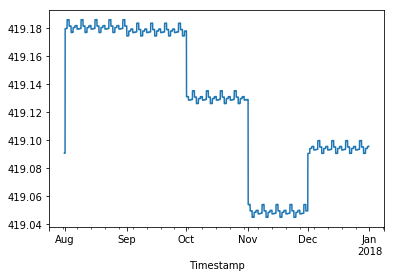

In [39]:
y_pred.plot()

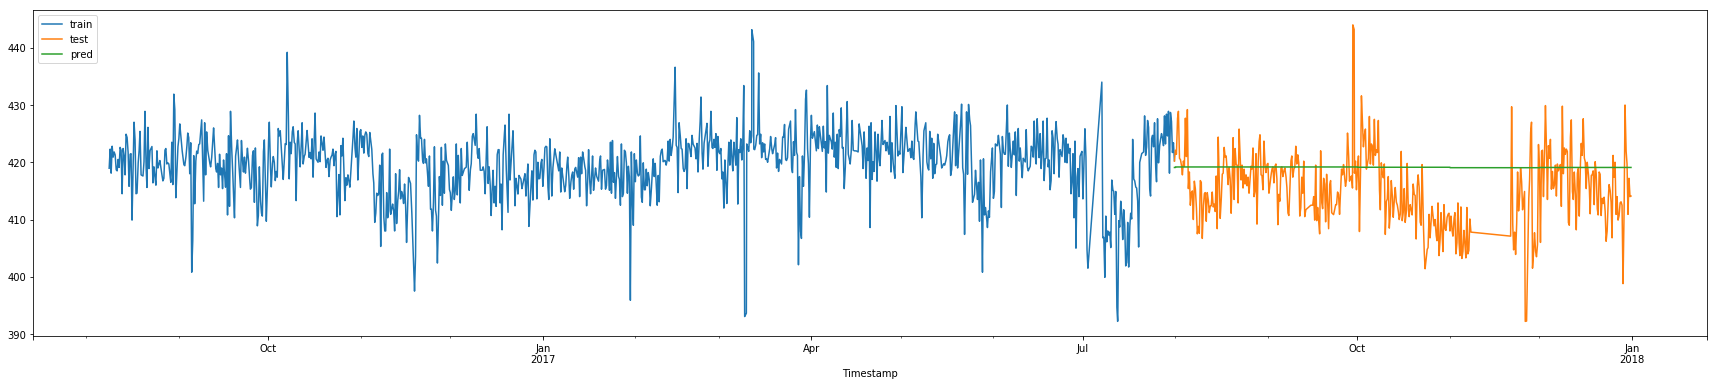

In [40]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [ ]:
reg = SVR(kernel='linear')

In [51]:
svrs = fit_model_cv(reg,x_tr_t.values,y_tr_t.values)

In [52]:
y_pred_val = np.zeros((y_ts_t.shape[0],len(svrs)))
y_pred_tr = np.zeros((y_tr_t.shape[0],len(svrs)))
for i, m in enumerate(svrs):
    y_pred_val[:,i]= m.predict(x_ts_t.values)
    y_pred_tr[:,i] = m.predict(x_tr_t.values)
y_pred_val = y_pred_val.mean(axis=1)
y_pred_tr = y_pred_tr.mean(axis=1)

In [53]:
y_pred = np.zeros((y_ts_t.shape[0],len(mdls)))
for i, m in enumerate(svrs):
    y_pred[:,i]= m.predict(x_ts_t.values)
y_pred = y_pred.mean(axis=1)

In [54]:
mse_tr = mean_squared_error(y_tr_t.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr_t.values, y_pred_tr)
r2_tr=r2_score(y_tr_t, y_pred_tr)
mse_ts = mean_squared_error(y_ts_t.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts_t.values, y_pred_val)
r2_ts = r2_score(y_ts_t.values, y_pred_val)

In [55]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 24.624075815701175 test: 53.66743986048546
RMSE train: 4.962265189981403 test: 7.3258064307273
MAE train: 3.5529632196639245 test: 5.993394929158636
R2 train: 0.08888822411655717 test: -0.5043326100512056


In [56]:
y_pred = pd.Series(data=y_pred, index=y_ts_t.index)

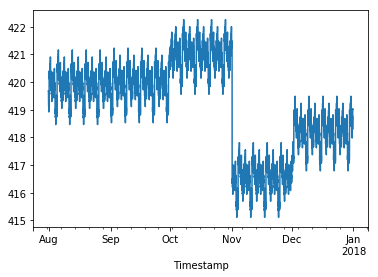

In [57]:
y_pred.plot()

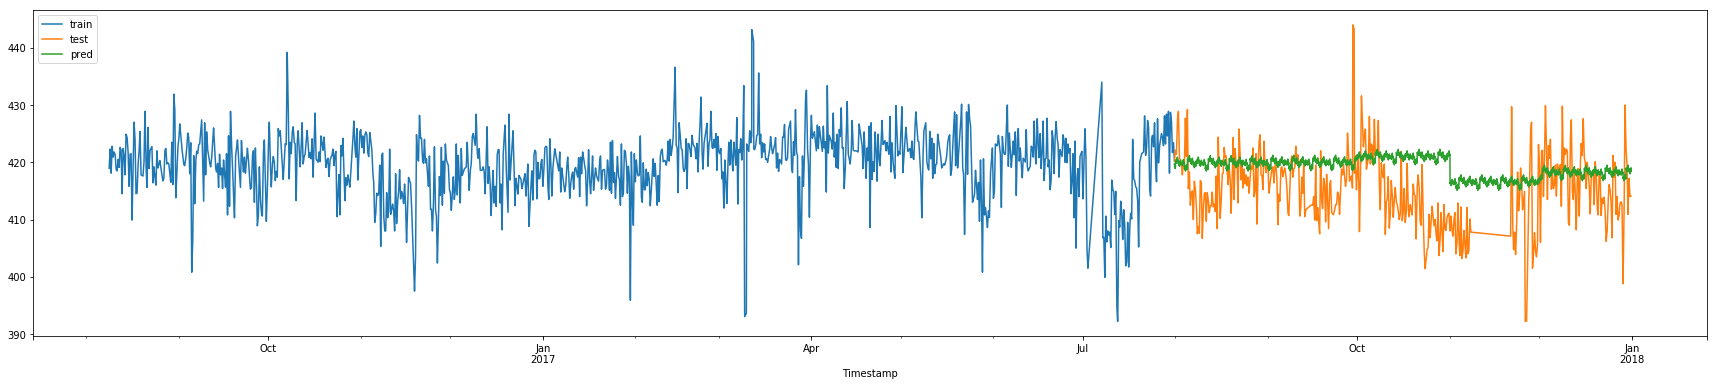

In [58]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [59]:
y_pred_time = y_pred.copy()

In [60]:
svrs_gauss = fit_model_cv(reg_3,x_tr_t.values,y_tr_t.values)
y_pred_val = np.zeros((y_ts_t.shape[0],len(svrs_gauss)))
y_pred_tr = np.zeros((y_tr_t.shape[0],len(svrs_gauss)))
for i, m in enumerate(svrs_gauss):
    y_pred_val[:,i]= m.predict(x_ts_t.values)
    y_pred_tr[:,i] = m.predict(x_tr_t.values)
y_pred_val = y_pred_val.mean(axis=1)
y_pred_tr = y_pred_tr.mean(axis=1)

In [61]:
y_pred = np.zeros((y_ts_t.shape[0],len(svrs_gauss)))
for i, m in enumerate(svrs_gauss):
    y_pred[:,i]= m.predict(x_ts_t.values)
y_pred = y_pred.mean(axis=1)

In [62]:
mse_tr = mean_squared_error(y_tr_t.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr_t.values, y_pred_tr)
r2_tr=r2_score(y_tr_t, y_pred_tr)
mse_ts = mean_squared_error(y_ts_t.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts_t.values, y_pred_val)
r2_ts = r2_score(y_ts_t.values, y_pred_val)

In [63]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 24.327569084646854 test: 54.38879990559726
RMSE train: 4.932298559966424 test: 7.374876263748244
MAE train: 3.524618216368464 test: 6.024088304446286
R2 train: 0.0998592256808083 test: -0.5245527927592069


In [64]:
y_pred = pd.Series(data=y_pred, index=y_ts_t.index)

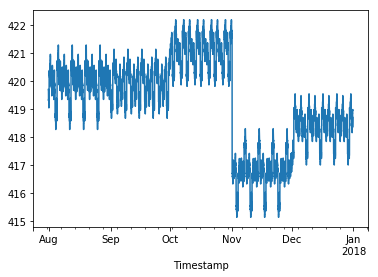

In [65]:
y_pred.plot()

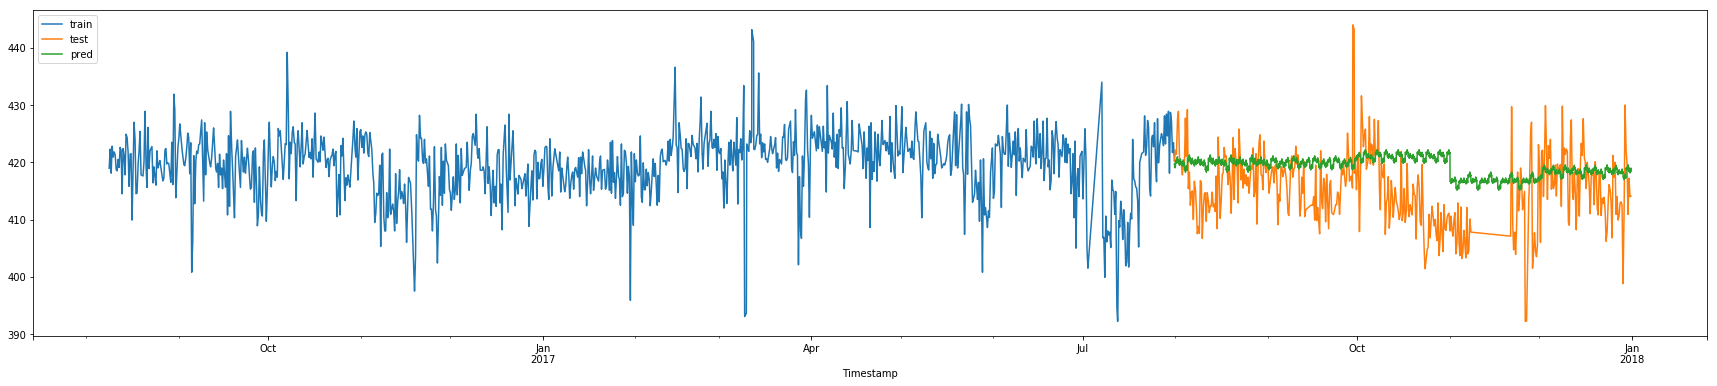

In [66]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [48]:
y_pred_time = y_pred.copy()

In [67]:
enets = fit_model_cv(reg_2,x_tr_t.values,y_tr_t.values)
y_pred_val = np.zeros((y_ts_t.shape[0],len(enets)))
y_pred_tr = np.zeros((y_tr_t.shape[0],len(enets)))
for i, m in enumerate(enets):
    y_pred_val[:,i]= m.predict(x_ts_t.values)
    y_pred_tr[:,i] = m.predict(x_tr_t.values)
y_pred_val = y_pred_val.mean(axis=1)
y_pred_tr = y_pred_tr.mean(axis=1)

In [68]:
y_pred = np.zeros((y_ts_t.shape[0],len(mdls)))
for i, m in enumerate(enets):
    y_pred[:,i]= m.predict(x_ts_t.values)
y_pred = y_pred.mean(axis=1)

In [69]:
mse_tr = mean_squared_error(y_tr_t.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr_t.values, y_pred_tr)
r2_tr=r2_score(y_tr_t, y_pred_tr)
mse_ts = mean_squared_error(y_ts_t.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts_t.values, y_pred_val)
r2_ts = r2_score(y_ts_t.values, y_pred_val)

In [70]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 27.014118668775687 test: 59.045848334812646
RMSE train: 5.197510814685785 test: 7.684129640682323
MAE train: 3.8535596326789494 test: 6.1852942655282614
R2 train: 0.00045460311082035076 test: -0.6550928341114435


In [71]:
y_pred = pd.Series(data=y_pred, index=y_ts_t.index)

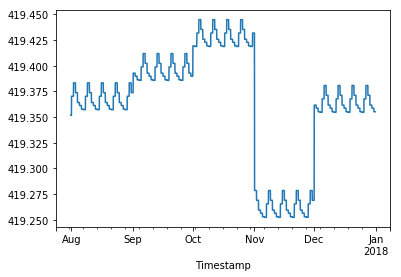

In [72]:
y_pred.plot()

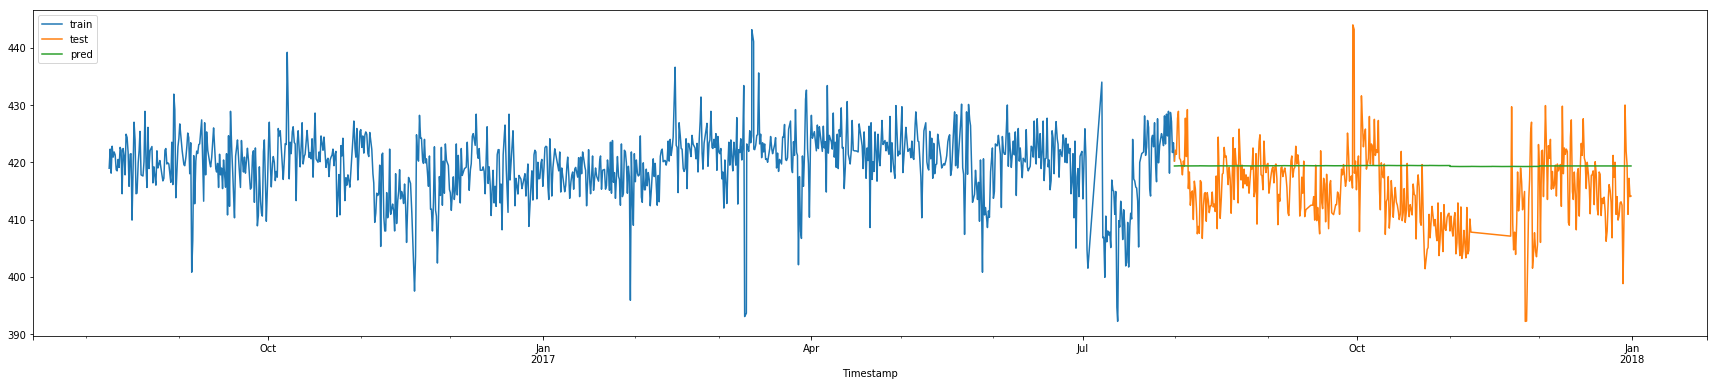

In [73]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [76]:
beststacked.fit(x_tr_n.values,y_tr.values)

StackingCVRegressor(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          meta_regressor=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
          refit=True,
          regressors=(AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123123), ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impu...23123, reg_alpha=0, reg_lambda=0.3,
       scale_pos_weight=1, seed=None, silent=True, subsample=1)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=True)

In [90]:
y_pred_time = y_pred.copy()

In [92]:
y_pred_tr = beststacked.predict(x_tr_n.values)
y_pred_val = beststacked.predict(x_ts_n.values)

In [93]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [94]:
mse_tr = mean_squared_error(y_tr_n.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr_n.values, y_pred_tr)
r2_tr=r2_score(y_tr_n, y_pred_tr)
mse_ts = mean_squared_error(y_ts_n.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts_n.values, y_pred_val)
r2_ts = r2_score(y_ts_n.values, y_pred_val)

In [95]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 18.43060236901514 test: 27.784144589178755
RMSE train: 4.293087742990486 test: 5.27106674110457
MAE train: 3.0494182538293395 test: 4.0865958673708125
R2 train: 0.31805201621708834 test: 0.22119268486564103


In [96]:
y_pred = pd.Series(data=y_pred_val, index=y_ts_n.index)

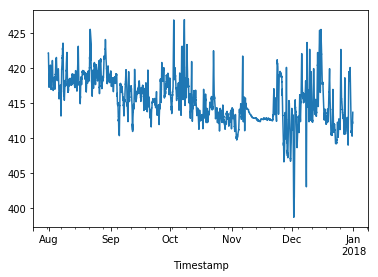

In [97]:
y_pred.plot()

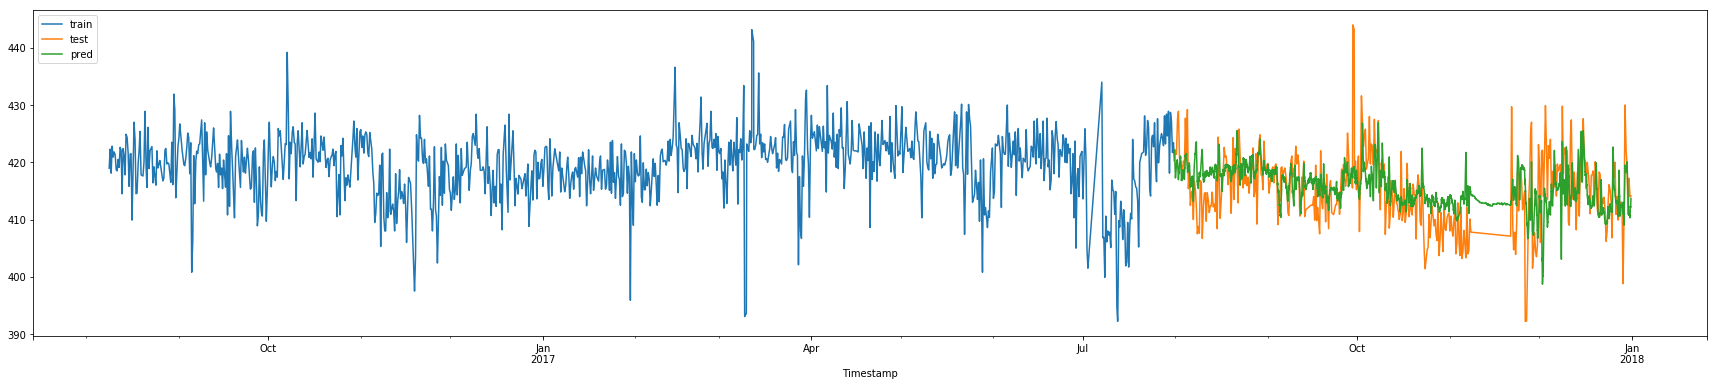

In [98]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr_n.plot(label='train')
y_ts_n.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [ ]:
y_pred_num = y_pred.copy()

In [74]:
#predictions from time features
y_pred_final_time = np.zeros((ts_time.shape[0],len(svrs)))
for i, m in enumerate(svrs):
    y_pred_final_time[:,i]= m.predict(ts_time.values)
y_pred_final_time = y_pred_final_time.mean(axis=1)

In [77]:
#predictions from sensor variables
y_pred_final_num = beststacked.predict(ts_num.values)

In [87]:
w1=0.8
w2=1-w1
y_pred_final = y_pred_final_num*w1 + y_pred_final_time*w2

In [88]:
finalpred = pd.Series(data=y_pred_final,index=ts_time.index)
timepred = pd.Series(data=y_pred_final_time, index=ts_time.index)
numpred = pd.Series(data=y_pred_final_num, index=ts_time.index)

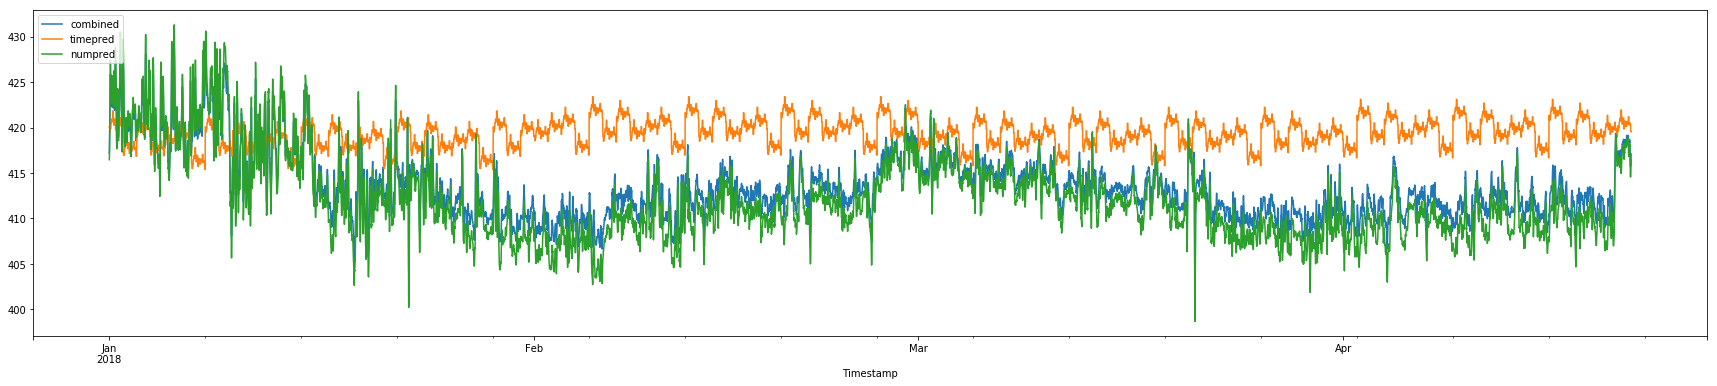

In [89]:
fig, ax = plt.subplots(figsize=(30,6))
finalpred.plot(label='combined')
timepred.plot(label='timepred')
numpred.plot(label='numpred')
plt.legend(loc='upper left')